In [3]:
!pip install jovian --upgrade --quiet

# **OBJECTIVE :**

To classify the images into six different classes. The image data is of natural scenes around the world. The data contains around 25k images of size 150 X 150 distributed under 6 categories. 

This dataset is used in this project is taken from kaggle. It was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

In [4]:
# To change the current directory to Google Drive as the dataset is already loaded there for easy access.

import os 
from google.colab import drive

#mount google drive to use it
drive.mount('/content/drive')

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/My Project Folder/"

# change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)


Mounted at /content/drive


In [5]:
#To check the current directory 

!pwd

/content/drive/My Drive/Colab Notebooks/My Project Folder


In [6]:
# Importing required libraries

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

The dataset is already downloaded into current directory using kaggle api command. Then it is unzipped into the project folder. 

In [7]:
# Looking into current directory

DATA_DIR = '.'

# Contains training images
TRAIN_DIR = DATA_DIR + '/seg_train/seg_train'                          

# Contains testing images
TEST_DIR = DATA_DIR + '/seg_test/seg_test'            

# Contains images to predict
PRED_DIR = DATA_DIR + '/seg_pred'      

# Printing all the files of the current folder
print(os.listdir(DATA_DIR))

# Getting classes/labels for classification
classes = os.listdir(TRAIN_DIR)
print("\n",classes)

['new_file_in_working_directory.txt', 'kaggle.json', 'intel-image-classification.zip', 'intel_image_data', 'seg_pred', 'seg_test', 'seg_train', 'IntelImageClassification.pth']

 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Creating training and testing datasets using ImageFolder Class

In [8]:
# Applying some transformations to the images.

image_size = 75         # image size
batch_size = 128        # batch size

#Stats from imagenet so that we can use transfer learning
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# training dataset
train_ds = ImageFolder(TRAIN_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.Pad(4, padding_mode='reflect'),
                                            T.RandomCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [9]:
# testing dataset (Also used for validation)
test_ds = ImageFolder(TEST_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.Pad(4, padding_mode='reflect'),
                                            T.RandomCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [10]:
# prediction dataset
pred_ds = ImageFolder(PRED_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.Pad(4, padding_mode='reflect'),
                                            T.RandomCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [11]:
# To see how many images are there in each dataset
len(train_ds) , len(test_ds), len(pred_ds)

(14034, 3000, 7301)

In [12]:
# Helper functions to denormalize and show images.

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Some example images along with it's label

Label: buildings (0)


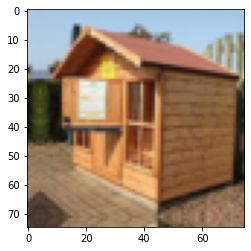

In [13]:
show_image(*train_ds[9])

Label: glacier (2)


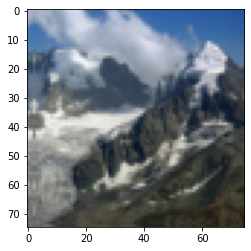

In [14]:
show_image(*train_ds[6589])

Label: street (5)


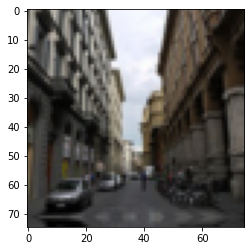

In [15]:
show_image(*train_ds[13568])

In [16]:
# Creating dataloaders for training and validation datasets

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

## Modifying a Pretrained Model (ResNet34)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
# IntelImageClassification Definition

class IntelImageClassification(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Using one fit one lr cycle using 

In [20]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
jovian.commit(project='course-project-dl')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/rijulbathla8/course-project-dl


'https://jovian.ai/rijulbathla8/course-project-dl'

In [22]:
# Checking if GPU is available or not

device = get_default_device()
device

device(type='cuda')

In [23]:
# Moving the dataloaders to the GPU 

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [24]:
# Initiating the model and moving it to the GPU

model = IntelImageClassification(len(classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [25]:
# Evaluating model before training

history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.23278985917568207, 'val_loss': 1.9112391471862793}]

Validation accuracy before training comes out to be around 23% as the weights are randomly initialised. 

## Training and Finetuning the model

In [26]:
# Hyperparameters 

epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
# Training with the above hyperparameters

%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00757, train_loss: 0.6093, val_loss: 1.4004, val_acc: 0.5692



Epoch [1],last_lr: 0.00950, train_loss: 0.6076, val_loss: 0.7081, val_acc: 0.7275



Epoch [2],last_lr: 0.00611, train_loss: 0.5699, val_loss: 1.2485, val_acc: 0.6079



Epoch [3],last_lr: 0.00188, train_loss: 0.4488, val_loss: 0.3858, val_acc: 0.8678



Epoch [4],last_lr: 0.00000, train_loss: 0.3038, val_loss: 0.3287, val_acc: 0.8879
CPU times: user 43.8 s, sys: 12.6 s, total: 56.4 s
Wall time: 12min 5s


The model took around 7 minutes for the first epoch and 5 minutes for rest of the epochs. 

Model achieved a validation accuracy of **around 88% in 5 epochs**.

## Model Evaluation

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

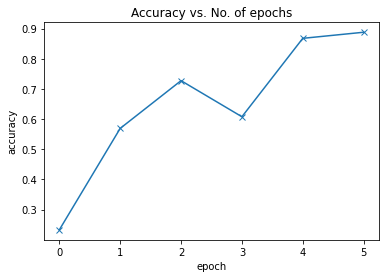

In [29]:
plot_accuracies(history)

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

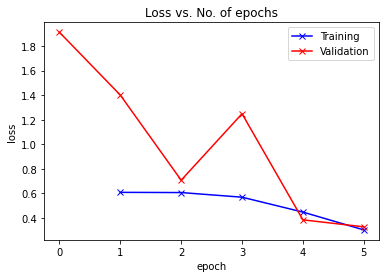

In [31]:
plot_losses(history)

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

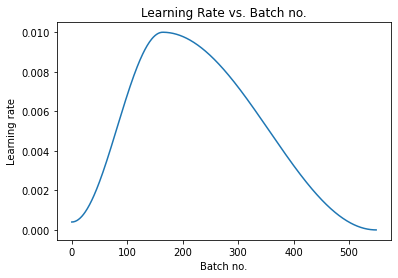

In [33]:
plot_lrs(history)

In [34]:
torch.save(model.state_dict(), 'IntelImageClassification.pth')

In [35]:
jovian.reset()
jovian.log_hyperparams(arch='pretrained(ResNet34)', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [36]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [37]:
jovian.commit(project='course-project-dl', environment=None, outputs=['IntelImageClassification.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rijulbathla8/course-project-dl


'https://jovian.ai/rijulbathla8/course-project-dl'

## Testing on individual images

In [38]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: buildings , Predicted: buildings


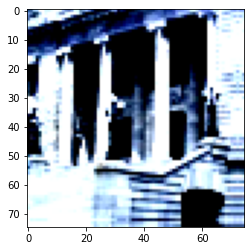

In [41]:
# using a random image 
img, label = test_ds[24]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: forest , Predicted: forest


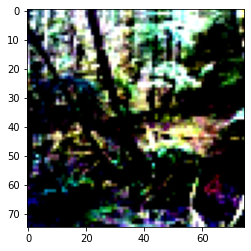

In [43]:
# using a random image 
img, label = test_ds[594]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [44]:
pred_dl = DataLoader(pred_ds, batch_size, num_workers=4, pin_memory=True)
pred_dl = DeviceDataLoader(pred_dl, device)

In [ ]:
 # Predict on the pred folder here

## Model without using pretrained layers

In [46]:
model2 = IntelImageClassification( len(classes) , pretrained=False)
to_device(model2, device);

In [47]:
history2 = [evaluate(model2, valid_dl)]
history2

[{'val_acc': 0.1865234375, 'val_loss': 12.629034042358398}]

In [48]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00757, train_loss: 1.0468, val_loss: 1.2116, val_acc: 0.5786



Epoch [1],last_lr: 0.00950, train_loss: 0.8804, val_loss: 1.1268, val_acc: 0.6039



Epoch [2],last_lr: 0.00611, train_loss: 0.7052, val_loss: 1.2491, val_acc: 0.6182



Epoch [3],last_lr: 0.00188, train_loss: 0.5695, val_loss: 0.5438, val_acc: 0.8090



Epoch [4],last_lr: 0.00000, train_loss: 0.4563, val_loss: 0.4731, val_acc: 0.8370
CPU times: user 40.8 s, sys: 7.56 s, total: 48.3 s
Wall time: 2min 40s
